In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>div.prompt {display:none}</style>"))
display(HTML("<style>div.input {display:none}</style>"))

from ipywidgets import interact, IntSlider

import datetime
import plotly.express as px

from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt

from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from matplotlib import image
import webp

current_period = 1

In [2]:
lines = []

filename = '..\\iscottb122.github.io\\data.txt'
with open(filename, encoding='UTF-8') as file:
    for line in file:
        if line == '\n': continue
        lines.append(line.rstrip())

In [3]:
# Meta data
position_data = pd.Series({'GK': 1, 'DF': 2, 'MF': 3, 'FW': 4})
max_players = 11

points_data = {}
points_data['GK'] = pd.Series({'Goal': 10,
                               'Assist': 3,
                               'CS': 5,
                               'Penalty': 3,
                               'Save': 2,
                               'OG': -1,
                               'Miss': -2,
                               'Red': -2,
                              })

points_data['DF'] = pd.Series({'Goal': 7,
                               'Assist': 3,
                               'CS': 4,
                               'Penalty': 2,
                               'Save': 10,
                               'OG': -2,
                               'Miss': -2,
                               'Red': -2,
                              })

points_data['MF'] = pd.Series({'Goal': 6,
                               'Assist': 3,
                               'CS': 0,
                               'Penalty': 2,
                               'Save': 10,
                               'OG': -2,
                               'Miss': -2,
                               'Red': -2,
                              })

points_data['FW'] = pd.Series({'Goal': 5,
                               'Assist': 3,
                               'CS': 0,
                               'Penalty': 2,
                               'Save': 10,
                               'OG': -2,
                               'Miss': -2,
                               'Red': -2,
                              })

points_data = pd.DataFrame(points_data).stack().reset_index()
points_data.columns = ['event', 'position', 'points']

In [4]:
managers = []
players = []
country_teams = []
manager_players = {}
events_data = []
period_player_transfers = []
period_events = []
period = 0

i = 0
while i < len(lines):
# for i in np.arange(len(lines)):
    if lines[i].split()[0] == 'Manager':
        manager = lines[i].split()[-2] + ' ' + lines[i].split()[-1]
        managers.append(manager)
        manager_players[manager] = []
        
    if lines[i].split()[0] == 'Country':
        country = lines[i].split()[-1]
        i = i + 1
                
        while lines[i].split()[0] == 'Player':
            player_name = lines[i][10:]
            players.append([lines[i].split()[1], player_name])
            country_teams.append([country, player_name])
            i = i + 1
        i = i - 1

    # Assume managers have been populated by this point
    if lines[i].split()[0] == 'Draft':
        while lines[i].split()[0] == 'Draft':         
            for manager in managers:
                player = lines[i][6:]
                manager_players[manager].append(player)
                i = i + 1
            
            if np.all([len(manager_players[manager]) == max_players for manager in managers]):
                break;
            
            for manager in managers[::-1]:
                player = lines[i][6:]
                manager_players[manager].append(player)
                i = i + 1
                
            if i == len(lines): break;
        i = i - 1
    
    if i >= len(lines): break;
    
    if lines[i].split()[0] == 'Out':
        if period == 0:
            period_player_transfers.append([period, lines[i][4:], lines[i+1][3:]])
        else:
            period_player_transfers.append([period + 1, lines[i][4:], lines[i+1][3:]])
        if i >= len(lines): break;
        
    if lines[i].split()[0] == 'Transfer':
        period = period + 1
        
    if lines[i].split()[0] == 'Assist':
        player = lines[i][7:]
        events_data.append([period, lines[i].split()[0], player])
        
    if lines[i].split()[0] == 'Goal':
        player = lines[i][5:]
        events_data.append([period, lines[i].split()[0], player])        
        
    if lines[i].split()[0] == 'Miss':
        player = lines[i][5:]
        events_data.append([period, lines[i].split()[0], player])
        
    if lines[i].split()[0] == 'Save':
        player = lines[i][5:]
        events_data.append([period, lines[i].split()[0], player])        
        
    if lines[i].split()[0] == 'CS':
        player = lines[i][3:]
        events_data.append([period, lines[i].split()[0], player])
        
    if lines[i].split()[0] == 'OG':
        player = lines[i][3:]
        events_data.append([period, lines[i].split()[0], player])  
        
    if lines[i].split()[0] == 'Red':
        player = lines[i][4:]
        events_data.append([period, lines[i].split()[0], player])
        
    if lines[i].split()[0] == 'Penalty':
        player = lines[i][8:]
        events_data.append([period, lines[i].split()[0], player])        

    i = i + 1
    
players = pd.DataFrame(players)
players.columns = ['position', 'player_name']    
    
events_data = pd.DataFrame(events_data)
events_data.columns = ['period', 'event', 'player_name']    

country_teams = pd.DataFrame(country_teams)
country_teams.columns = ['country', 'player_name']

In [5]:
country_list = country_teams['country'].unique()
country_flag_locations = 'flags\\'

In [6]:
events_data = pd.merge(events_data,
                       players,
                       on=['player_name'],
                       how='left')


events_data = pd.merge(events_data,
                       points_data,
                       on=['position', 'event'],
                       how='left')

events_data_grouped = events_data.groupby(['period', 'player_name', 'position'])['points'].sum().reset_index()

# Latest period points for players

In [7]:
events_data_grouped[events_data_grouped['period'] == current_period].sort_values('points', ascending=False)[['player_name', 'position', 'points']].reset_index(drop=True)

player_name position  points
0        Bukayo Saka       FW      10
1       Mehdi Taremi       FW      10
2     Enner Valencia       FW      10
3    Raheem Sterling       FW       8
4    Ángelo Preciado       DF       7
5         Harry Kane       FW       6
6      Davy Klaassen       MF       6
7    Jude Bellingham       MF       6
8    Marcus Rashford       FW       5
9      Jack Grealish       FW       5
10   Andries Noppert       GK       5
11   Hernán Galíndez       GK       5
12        Cody Gakpo       FW       5
13      Félix Torres       DF       4
14   Denzel Dumfries       DF       4
15       Daley Blind       DF       4
16  Matthijs de Ligt       DF       4
17        Nathan Aké       DF       4
18  Pervis Estupiñán       DF       4
19    Piero Hincapié       DF       4
20   Virgil van Dijk       DF       4
21     Harry Maguire       DF       3
22   Frenkie de Jong       MF       3
23         Luke Shaw       DF       3
24     Callum Wilson       FW       3
25    Ali Gholizadeh       MF       3

# Top ten players in tournament

In [8]:
events_data_grouped.groupby(['player_name', 'position'])['points'].sum().reset_index().sort_values('points', ascending=False).head(10).reset_index(drop=True)

player_name position  points
0      Bukayo Saka       FW      10
1     Mehdi Taremi       FW      10
2   Enner Valencia       FW      10
3  Raheem Sterling       FW       8
4  Ángelo Preciado       DF       7
5       Harry Kane       FW       6
6    Davy Klaassen       MF       6
7  Jude Bellingham       MF       6
8  Marcus Rashford       FW       5
9    Jack Grealish       FW       5

In [9]:
period_player_transfers = pd.DataFrame(period_player_transfers)
period_player_transfers.columns = ['period', 'in', 'out']

periods = np.arange(period_player_transfers['period'].max())

In [10]:
period_player_transfers

period                  in                 out
0       0       Thomas Müller     Steven Berghuis
1       0       Karim Benzema  Robert Lewandowski
2       2  Robert Lewandowski       Karim Benzema
3       2         Kai Havertz  Robert Lewandowski
4       2       Karim Benzema     Raheem Sterling
5       2     Steven Berghuis       Thomas Müller

In [11]:
player_name_short_list = []

for player in players['player_name']:
    if len(player.split()) == 1:
        player_name_short_list.append(player.split()[0])
    else:
        player_name_short = player.split()[-1]
        
        for i in player.split()[:-1]:
            player_name_short = player_name_short + " {}.".format(i[0])
        player_name_short_list.append(player_name_short)
    
players['player_name_short'] = player_name_short_list

In [12]:
manager_players_picks = pd.DataFrame(manager_players).stack().reset_index()
manager_players_picks.columns = ['pick_number', 'manager', 'player_name']
manager_players_initial = manager_players_picks[['manager', 'player_name']]

In [13]:
manager_players_full = []

for period in periods:
    print(period)
    if period == 0:
        manager_players_temp = manager_players_initial.copy()
    else:
        manager_players_temp = manager_players_temp_previous.copy()
    
    manager_players_temp['period'] = period
    
    period_transfers = period_player_transfers[period_player_transfers['period'] == period - 1]
    if len(period_transfers) > 0:
        for i in np.arange(len(period_transfers)):
            manager_players_temp = manager_players_temp.replace({
                                        'player_name': {period_transfers.iloc[i]['in']: period_transfers.iloc[i]['out']}
                                   })
    manager_players_full.append(manager_players_temp)
    manager_players_temp_previous = manager_players_temp.copy()
    
manager_players_full = pd.concat(manager_players_full)

0
1


In [14]:
manager_players_full = pd.merge(manager_players_full,
                                players,
                                on=['player_name'],
                                how='left')

manager_players_full = pd.merge(manager_players_full,
                                position_data.to_frame().rename(columns={0: 'position_number'}),
                                left_on='position',
                                right_index=True,
                                how='left')

manager_players_full = pd.merge(manager_players_full,
                                events_data_grouped,
                                on=['period', 'player_name', 'position'],
                                how='left')

manager_players_full = pd.merge(manager_players_full,
                                country_teams,
                                on=['player_name'],
                                how='left')

In [15]:
def position_to_pitch(ax, positions, position_level, position_names):
    for i in np.arange(len(positions)):
        text_pos = ax.text(positions[i], 
                           position_level, 
                           "{}\n{}".format(position_names['player_name_short'].iloc[i], int(position_names['points'].replace(np.nan, 0).iloc[i])), 
                           color="white", 
                           fontsize=18, 
                           fontweight='bold',
                           horizontalalignment='center')
#         pixel_positions = text_pos.get_transform().transform(values=(positions[i], position_level))
        
#         print(positions[i], position_level, pixel_positions)
        
#         country_flag_file = "{}{}.webp".format(country_flag_locations, position_names['country'].iloc[i])
#         country_flag_image = webp.load_image(country_flag_file, 'RGB')
        
#         size_multiplier = 1.5
#         country_flag_image = country_flag_image.resize((int(country_flag_image.size[0] * size_multiplier), 
#                                                         int(country_flag_image.size[1] * size_multiplier)))
        
#         ax.figure.figimage(country_flag_image,
#                            pixel_positions[0],
#                            pixel_positions[1],
#                            origin='upper')

def team_to_formation(ax, team):
    gk_level = 115
    df_level = 96
    mf_level = 80
    fw_level = 65
    
    positions = {1: [40],
                 2: [25, 45],
                 3: [20, 40, 60],
                 4: [10, 30, 50, 70],
                 5: [5, 20, 40, 60, 75]}
    
    gk_positions = positions[len(team[team['position']=='GK'])]
    df_positions = positions[len(team[team['position']=='DF'])]
    mf_positions = positions[len(team[team['position']=='MF'])]
    fw_positions = positions[len(team[team['position']=='FW'])]
    
    position_to_pitch(ax, 
                      gk_positions, 
                      gk_level,
                      team[team['position']=='GK'][['player_name_short', 'country', 'points']])
    
    position_to_pitch(ax, 
                      df_positions, 
                      df_level,
                      team[team['position']=='DF'][['player_name_short', 'country', 'points']])
    
    position_to_pitch(ax, 
                      mf_positions, 
                      mf_level,
                      team[team['position']=='MF'][['player_name_short', 'country', 'points']])    
    
    position_to_pitch(ax, 
                      fw_positions, 
                      fw_level,
                      team[team['position']=='FW'][['player_name_short', 'country', 'points']])    


In [16]:
def plot_pitch_and_team(manager_players_full_selected):
    pitch = VerticalPitch(pitch_color='grass', line_color='white', stripe=True, half=True)

    # specifying figure size (width, height)
    fig, ax = pitch.draw(figsize=(15, 8))

    team_to_formation(ax, team=manager_players_full_selected)

    plt.show()    

# Teams

In [17]:
latest_period = periods[-1]
manager_players_full_latest = manager_players_full[manager_players_full['period'] == current_period]

## Mitesh

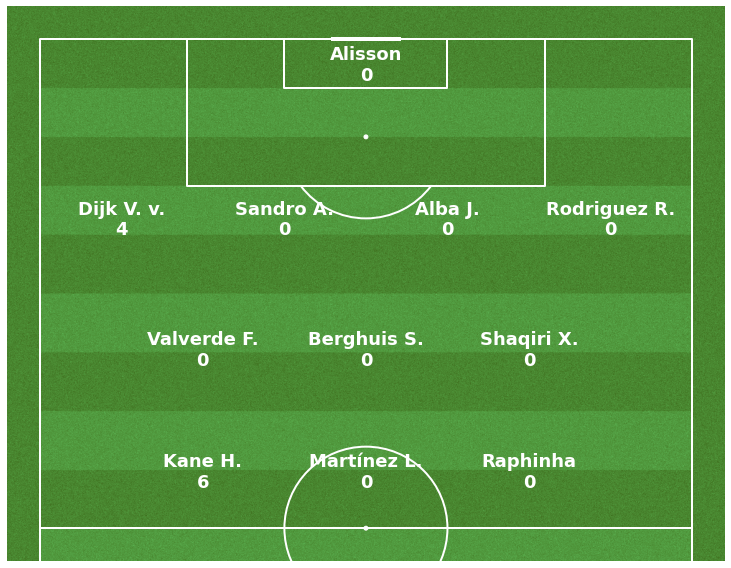

In [18]:
manager = 'Mitesh Patel'
plot_pitch_and_team(manager_players_full_latest[manager_players_full_latest['manager'] == manager])

## Stephen

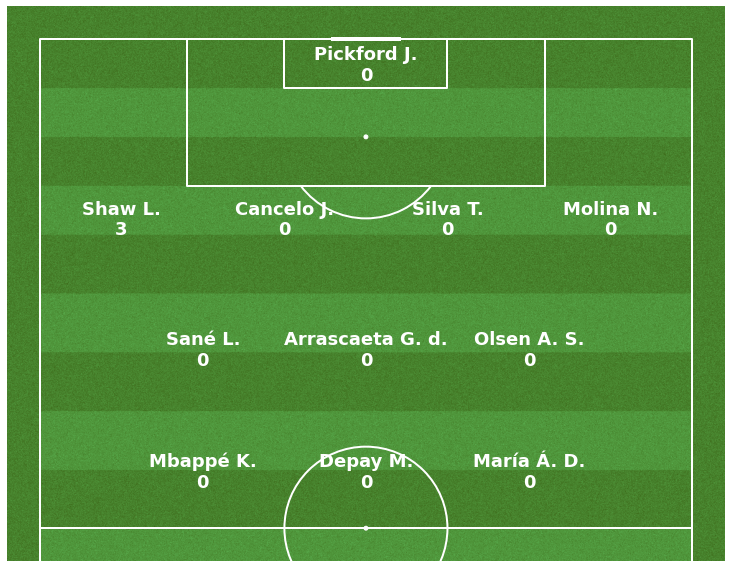

In [19]:
manager = 'Stephen Brooks'
plot_pitch_and_team(manager_players_full_latest[manager_players_full_latest['manager'] == manager])

## Santos

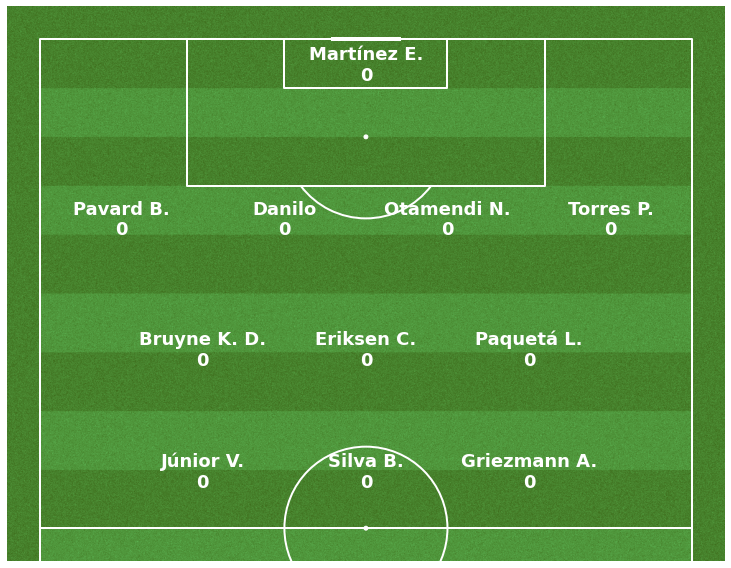

In [20]:
manager = 'Ed Santos'
plot_pitch_and_team(manager_players_full_latest[manager_players_full_latest['manager'] == manager])

## Tom

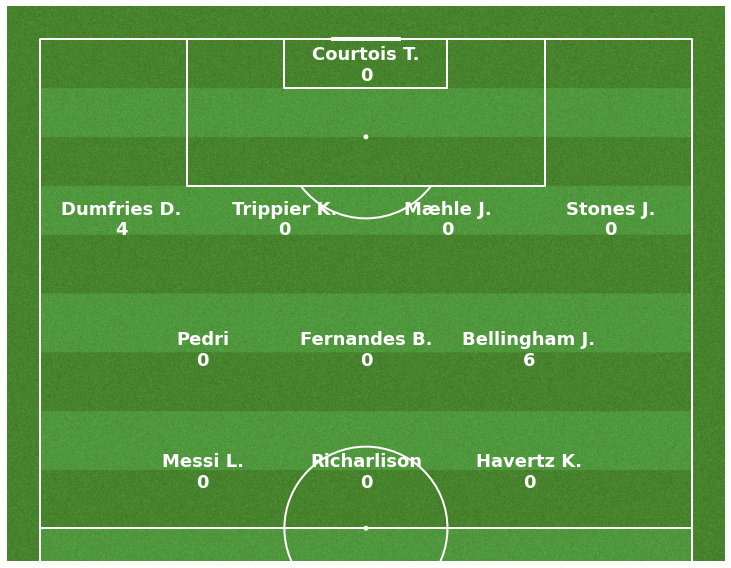

In [21]:
manager = 'Tom Paton'
plot_pitch_and_team(manager_players_full_latest[manager_players_full_latest['manager'] == manager])

## Iain

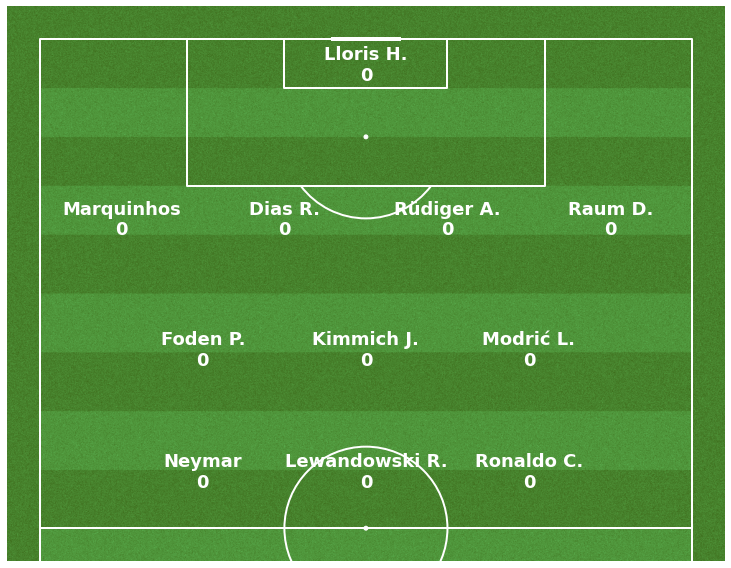

In [22]:
manager = 'Iain Scott'
plot_pitch_and_team(manager_players_full_latest[manager_players_full_latest['manager'] == manager])

# Performance

In [23]:
player_team_performance = (manager_players_full.groupby(['period', 'manager'])['points']
                           .sum().reset_index()
                           .pivot(index='period', columns='manager', values='points').cumsum())

In [24]:
fig = px.line(player_team_performance, title='Period performance')
fig.show()

## Performance rank

In [25]:
(player_team_performance
 .rank(1, ascending=False).astype(int)
 .T.style.background_gradient(cmap='RdBu')
 .set_properties(**{'width': '2em', 'text-align': 'center'}))

## Position rank

In [26]:
(player_team_performance.cumsum()
 .rank(1, ascending=False).astype(int)
 .T.style.background_gradient(cmap='RdBu')
 .set_properties(**{'width':'2em', 'text-align': 'center'}))

## Manager player performances

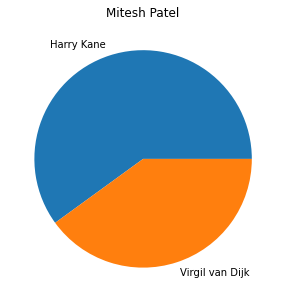

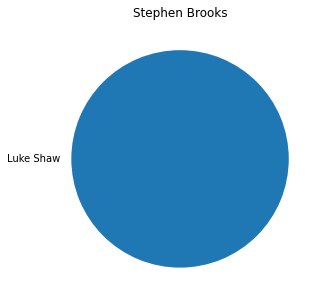

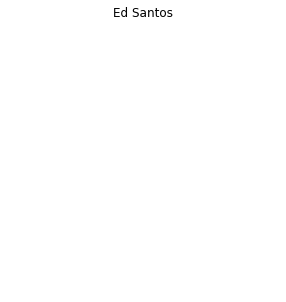

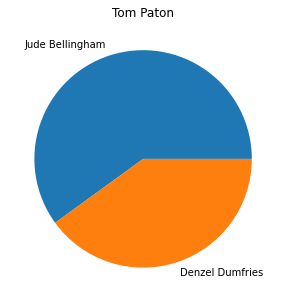

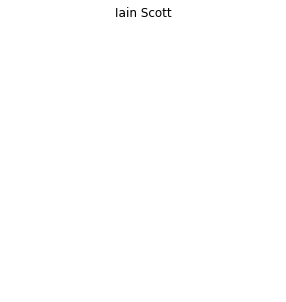

In [27]:
manager_player_performances = (manager_players_full
                               .groupby(['manager', 'player_name'])['points'].sum().reset_index())

for manager in managers:  
    (manager_player_performances[manager_player_performances['manager'] == manager]
     .drop(columns='manager').set_index('player_name').sort_values('points', ascending=False)
     .iloc[:10]
     .plot.pie(y='points', figsize=(5,5), title=manager, legend=False, ylabel=''));

## Players used

In [28]:
fig = px.bar(manager_players_full.groupby('manager')['player_name'].nunique().sort_values(ascending=False),
             title='Most players used', 
             labels={'value':'Number of unique players', 
                     'user_name':''})
fig.layout.update(showlegend=False)
fig.show()